# HTAB Parameter Optimization for Model Stability

This notebook demonstrates how to optimize Hydraulic Table (HTAB) parameters in HEC-RAS geometry files to improve model stability and prevent extrapolation errors.

## Overview

### What is HTAB?

HTAB (Hydraulic Table) parameters control how HEC-RAS pre-computes hydraulic property tables for:
- **Cross Sections**: Starting elevation, increment, and number of points
- **Structures**: Maximum headwater, tailwater, flow, and curve point counts

### Why HTAB Optimization Matters

**Extrapolation Errors**: When water surface elevations exceed the HTAB range, HEC-RAS must extrapolate beyond the computed property tables. This can cause:
- Warning messages in compute logs
- Numerical instability
- Inaccurate hydraulic calculations
- Model convergence issues

**Solution**: Optimize HTAB parameters based on actual simulation results to ensure adequate coverage.

### What You'll Learn

1. Read current HTAB parameters from geometry files
2. Run a baseline simulation and inspect compute messages
3. Clone plan and geometry to preserve baseline for comparison
4. Optimize HTAB parameters using `GeomHtab.optimize_all_htab_from_results()`
5. **Fix HTAB starting elevation issues using `RasFixit.fix_htab_starting_elevations()`**
6. Visualize before/after parameter comparisons
7. Compare results using `results_df` and max WSEL analysis
8. Assess computational differences between baseline and optimized plans

### LLM Forward Approach

- **Verification**: Compare compute messages before and after optimization
- **Visual Outputs**: Bar charts and coverage plots for HTAB parameters
- **Audit Trail**: Automatic backups of modified geometry files

## Setup and Imports

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
from pathlib import Path
import sys

USE_LOCAL_SOURCE = True  # <-- TOGGLE THIS: True for local dev, False for pip

if USE_LOCAL_SOURCE:
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander modules
from ras_commander import (
    RasExamples,
    init_ras_project,
    RasCmdr,
    RasPlan,
    RasGeo,
    ras,
    HdfHydraulicTables,
)
from ras_commander.geom import (
    GeomCrossSection,
    GeomHtab,
    GeomHtabUtils,
)
from ras_commander.hdf import HdfResultsXsec, HdfResultsPlan

# Additional imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import warnings
warnings.filterwarnings('ignore')

# Verify which version loaded
import ras_commander
print(f"Loaded: {ras_commander.__file__}")
print(f"Working directory: {Path.cwd()}")

LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
Loaded: c:\GH\ras-commander\ras_commander\__init__.py
Working directory: c:\GH\ras-commander\examples


## Parameters

Configure these values to customize the notebook.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project with 1D cross sections
RAS_VERSION = "6.6"               # HEC-RAS version
PLAN_NUMBER = "01"                # Plan to execute and optimize

# HTAB Optimization Settings
XS_SAFETY_FACTOR = 1.3            # 30% safety margin on depth
STRUCTURE_HW_SAFETY = 2.0         # 100% safety on headwater
STRUCTURE_FLOW_SAFETY = 2.0       # 100% safety on flow
TARGET_INCREMENT = 0.1            # Target elevation increment (ft)
MAX_POINTS = 500                  # Maximum HTAB points (HEC-RAS limit)

print("Configuration:")
print(f"  Project: {PROJECT_NAME}")
print(f"  Plan: {PLAN_NUMBER}")
print(f"  XS Safety Factor: {XS_SAFETY_FACTOR} ({(XS_SAFETY_FACTOR-1)*100:.0f}% safety margin)")
print(f"  Structure Safety: {STRUCTURE_HW_SAFETY}x HW, {STRUCTURE_FLOW_SAFETY}x Flow")

Configuration:
  Project: Muncie
  Plan: 01
  XS Safety Factor: 1.3 (30% safety margin)
  Structure Safety: 2.0x HW, 2.0x Flow


## Section 1: Extract Project and Initialize

In [3]:
# Extract example project
project_path = RasExamples.extract_project(PROJECT_NAME, suffix="203_htab")
print(f"Project extracted to: {project_path}")

# Initialize project
init_ras_project(project_path, RAS_VERSION)

# Display project structure
print(f"\nPlans found: {len(ras.plan_df)}")
print(f"Geometries found: {len(ras.geom_df)}")

# Get geometry file path
geom_row = ras.geom_df[ras.geom_df['geom_number'] == '01'].iloc[0]
geom_file = Path(geom_row['full_path'])
print(f"\nGeometry file: {geom_file.name}")

2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Extracting project 'Muncie' as 'Muncie_203_htab'
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Folder 'Muncie_203_htab' already exists. Deleting existing folder...
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Existing folder 'Muncie_203_htab' has been deleted.
2026-01-14 10:33:41 - ras_commander.RasExamples - INFO - Successfully extracted project 'Muncie' to C:\GH\ras-commander\examples\example_projects\Muncie_203_htab
2026-01-14 10:33:42 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\

Project extracted to: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab

Plans found: 3
Geometries found: 3

Geometry file: Muncie.g01


## Section 2: Inspect Original HTAB Parameters

Before optimizing, let's examine the current HTAB parameters for cross sections.

In [4]:
# Get all cross sections
from ras_commander import RasGeometry
xs_df = RasGeometry.get_cross_sections(geom_file)
print(f"Total cross sections: {len(xs_df)}")

# Extract HTAB parameters for first 10 cross sections
htab_params_list = []
for idx, xs in xs_df.head(10).iterrows():
    try:
        params = GeomCrossSection.get_xs_htab_params(
            geom_file, xs['River'], xs['Reach'], xs['RS']
        )
        htab_params_list.append({
            'RS': xs['RS'],
            'Invert': params.get('invert'),
            'Starting_El': params.get('starting_el'),
            'Increment': params.get('increment'),
            'Num_Points': params.get('num_points'),
            'Max_El': (params.get('starting_el') or 0) + 
                      (params.get('increment') or 0) * ((params.get('num_points') or 1) - 1) 
                      if params.get('starting_el') and params.get('increment') else None
        })
    except Exception as e:
        print(f"  Warning: Could not read HTAB for RS {xs['RS']}: {e}")

original_htab_df = pd.DataFrame(htab_params_list)
print("\nOriginal HTAB Parameters (first 10 cross sections):")
display.display(original_htab_df)

2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted 63 cross sections from Muncie.g01
2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted 134 station/elevation pairs for White/Muncie/RS 15696.24
2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15696.24: has_htab_lines=True, starting_el=937.99, increment=0.5, num_points=100
2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted 93 station/elevation pairs for White/Muncie/RS 15485.51
2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15485.51: has_htab_lines=True, starting_el=938.78, increment=0.5, num_points=100
2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted 88 station/elevation pairs for White/Muncie/RS 15370.43
2026-01-14 10:33:42 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 

Total cross sections: 63

Original HTAB Parameters (first 10 cross sections):


,RS,Invert,Starting_El,Increment,Num_Points,Max_El
0,15696.24,936.99,937.99,0.5,100,987.49
1,15485.51,937.78,938.78,0.5,100,988.28
2,15370.43,937.78,945.16,0.5,100,994.66
3,15205.29,941.39,942.39,0.5,100,991.89
4,15013.20,940.73,941.73,0.5,100,991.23
5,14917.36,941.06,942.06,0.5,100,991.56
6,14856.24,940.18,941.18,0.5,100,990.68
7,14787.40,937.78,938.78,0.5,100,988.28
8,14697.22,938.88,939.88,0.5,100,989.38
9,14535.60,938.77,939.77,0.5,100,989.27


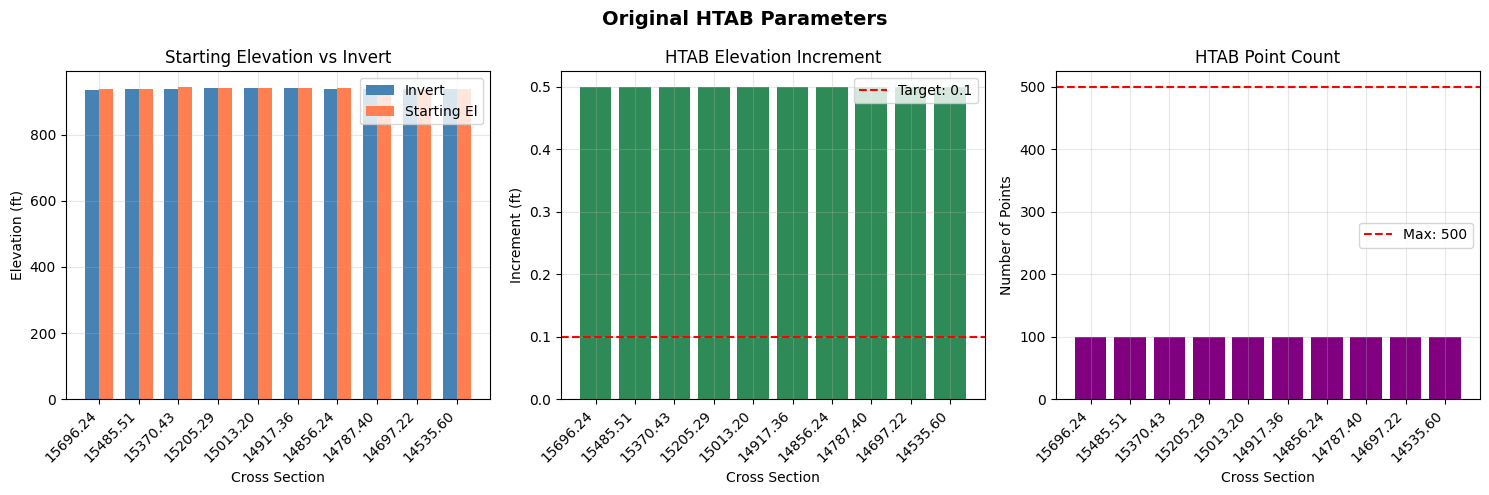

In [5]:
# Visualize original HTAB parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Filter out None values for plotting
plot_df = original_htab_df.dropna()
rs_labels = [str(rs)[:8] for rs in plot_df['RS']]

# Plot 1: Starting Elevation vs Invert
ax1 = axes[0]
x = np.arange(len(plot_df))
width = 0.35
ax1.bar(x - width/2, plot_df['Invert'], width, label='Invert', color='steelblue')
ax1.bar(x + width/2, plot_df['Starting_El'], width, label='Starting El', color='coral')
ax1.set_xlabel('Cross Section')
ax1.set_ylabel('Elevation (ft)')
ax1.set_title('Starting Elevation vs Invert')
ax1.set_xticks(x)
ax1.set_xticklabels(rs_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Increment
ax2 = axes[1]
ax2.bar(x, plot_df['Increment'], color='seagreen')
ax2.axhline(y=TARGET_INCREMENT, color='red', linestyle='--', label=f'Target: {TARGET_INCREMENT}')
ax2.set_xlabel('Cross Section')
ax2.set_ylabel('Increment (ft)')
ax2.set_title('HTAB Elevation Increment')
ax2.set_xticks(x)
ax2.set_xticklabels(rs_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Number of Points
ax3 = axes[2]
ax3.bar(x, plot_df['Num_Points'], color='purple')
ax3.axhline(y=MAX_POINTS, color='red', linestyle='--', label=f'Max: {MAX_POINTS}')
ax3.set_xlabel('Cross Section')
ax3.set_ylabel('Number of Points')
ax3.set_title('HTAB Point Count')
ax3.set_xticks(x)
ax3.set_xticklabels(rs_labels, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

fig.suptitle('Original HTAB Parameters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Section 3: Baseline Run and Compute Messages

Execute the plan with default HTAB parameters and check for extrapolation warnings.

In [6]:
# Execute baseline plan
print("Running baseline simulation...")
print("(This may take 1-2 minutes)\n")

result = RasCmdr.compute_plan(PLAN_NUMBER, num_cores=4, force_rerun=True)

if result:
    print("Baseline simulation completed successfully")
    
    # Get HDF path
    plan_row = ras.plan_df[ras.plan_df['plan_number'] == PLAN_NUMBER].iloc[0]
    hdf_path = Path(plan_row['HDF_Results_Path'])
    print(f"HDF results: {hdf_path.name}")
else:
    print("ERROR: Baseline simulation failed")

2026-01-14 10:33:42 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab
2026-01-14 10:33:42 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01
2026-01-14 10:33:42 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01
2026-01-14 10:33:42 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 01
2026-01-14 10:33:42 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2026-01-14 10:33:42 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01"


Running baseline simulation...
(This may take 1-2 minutes)



2026-01-14 10:33:58 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01
2026-01-14 10:33:58 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 15.60 seconds
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 2579 characters from HDF
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - 

Baseline simulation completed successfully
HDF results: Muncie.p01.hdf


In [7]:
# Parse compute messages to check for extrapolation warnings
from ras_commander import ResultsParser
from ras_commander.hdf import HdfResultsPlan

# Get plan HDF path
plan_row = ras.plan_df[ras.plan_df['plan_number'] == PLAN_NUMBER].iloc[0]
hdf_path = Path(plan_row['HDF_Results_Path'])

# Get compute messages text from HDF
compute_msgs_text = HdfResultsPlan.get_compute_messages(hdf_path)

# Parse messages
compute_result = ResultsParser.parse_compute_messages(compute_msgs_text)

print(f"Computation completed: {compute_result['completed']}")
print(f"Has warnings: {compute_result['has_warnings']}")
print(f"Warning count: {compute_result['warning_count']}")

# Check for extrapolation warnings in raw text
extrap_count = compute_msgs_text.lower().count('extrapolat')
htab_count = compute_msgs_text.lower().count('htab') + compute_msgs_text.lower().count('property table')

print(f"\nExtrapolation mentions: {extrap_count}")
print(f"HTAB-related mentions: {htab_count}")

# Store for comparison later
baseline_extrap_count = extrap_count
baseline_warning_count = compute_result['warning_count']

if extrap_count > 0:
    print("\nNote: Model may benefit from HTAB optimization")
else:
    print("\nNo extrapolation warnings found in baseline run.")

2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 2579 characters from HDF


Computation completed: True
Has warnings: False
Warning count: 0

Extrapolation mentions: 0
HTAB-related mentions: 0

No extrapolation warnings found in baseline run.


## Section 4: Extract Maximum WSE from Results

Analyze the simulation results to understand the required HTAB coverage.

In [8]:
# Extract cross section timeseries to get maximum WSE values
try:
    xs_results = HdfResultsXsec.get_xsec_timeseries(hdf_path)
    
    # Extract max WSE for each cross section
    cross_sections = xs_results.coords['cross_section'].values
    max_wse_values = xs_results.coords['Maximum_Water_Surface'].values
    rivers = xs_results.coords['River'].values
    reaches = xs_results.coords['Reach'].values
    stations = xs_results.coords['Station'].values
    
    # Build DataFrame
    max_wse_df = pd.DataFrame({
        'cross_section': cross_sections,
        'river': rivers,
        'reach': reaches,
        'station': stations,
        'max_wse': max_wse_values
    })
    
    # Store baseline max WSE for later comparison with optimized plan
    baseline_max_wse_df = max_wse_df.copy()
    baseline_max_wse_df = baseline_max_wse_df.rename(columns={'max_wse': 'max_wse_baseline'})
    
    print(f"Extracted max WSE for {len(max_wse_df)} cross sections")
    print(f"\nBaseline Max WSE Statistics:")
    print(f"  Min: {max_wse_df['max_wse'].min():.2f} ft")
    print(f"  Max: {max_wse_df['max_wse'].max():.2f} ft")
    print(f"  Mean: {max_wse_df['max_wse'].mean():.2f} ft")
    
    print("\nFirst 10 cross sections:")
    display.display(max_wse_df.head(10))
    
except Exception as e:
    print(f"Error extracting cross section results: {e}")
    max_wse_df = None
    baseline_max_wse_df = None

2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsXsec - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf


Extracted max WSE for 61 cross sections

Baseline Max WSE Statistics:
  Min: 938.73 ft
  Max: 955.42 ft
  Mean: 945.88 ft

First 10 cross sections:


,cross_section,river,reach,station,max_wse
0,White Muncie 15696.24,White,Muncie,15696.24,955.419312
1,White Muncie 15485.51,White,Muncie,15485.51,955.174011
2,White Muncie 15370.43,White,Muncie,15370.43,954.952271
3,White Muncie 15205.29,White,Muncie,15205.29,954.893005
4,White Muncie 15013.20,White,Muncie,15013.20,954.560486
5,White Muncie 14917.36,White,Muncie,14917.36,953.986633
6,White Muncie 14856.24,White,Muncie,14856.24,953.586487
7,White Muncie 14787.40,White,Muncie,14787.40,953.695190
8,White Muncie 14697.22,White,Muncie,14697.22,953.339478
9,White Muncie 14535.60,White,Muncie,14535.60,953.233215


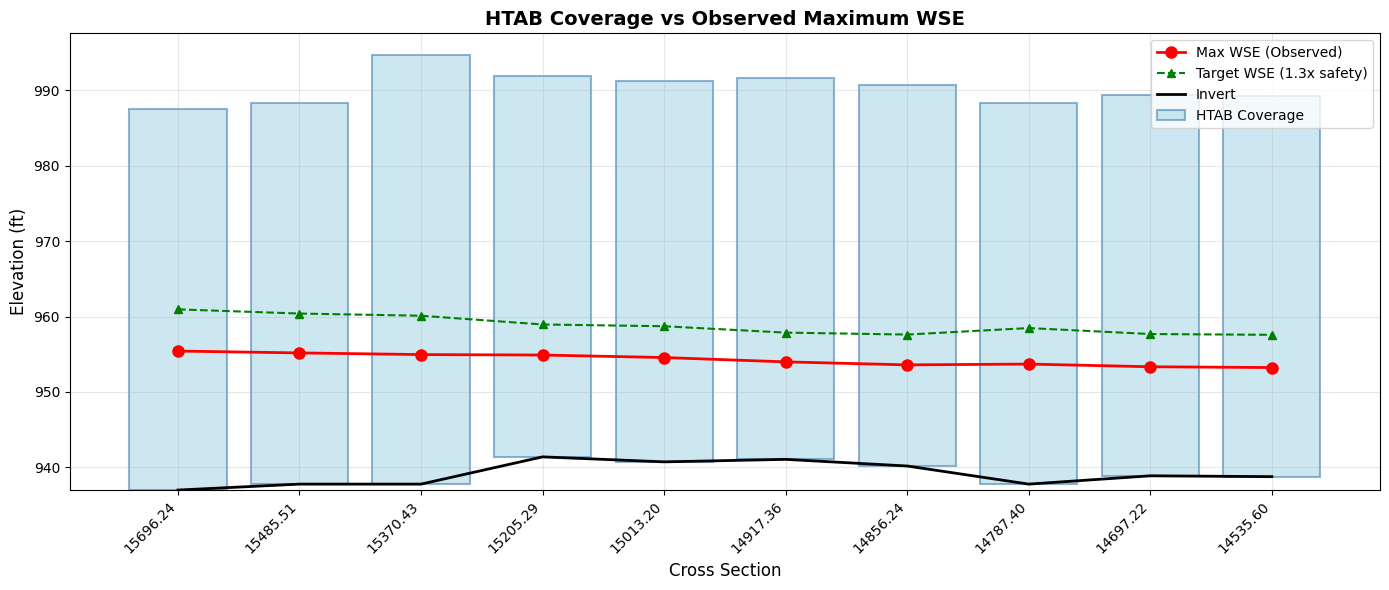


Coverage Analysis:
- Blue bars: Current HTAB elevation range
- Red dots: Maximum observed water surface elevation
- Green triangles: Target WSE with safety factor

If red dots approach or exceed the blue bars, HTAB optimization is needed.


In [9]:
# Visualize HTAB coverage vs observed WSE
if max_wse_df is not None and len(original_htab_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Merge original HTAB with max WSE
    plot_df = original_htab_df.head(10).copy()
    plot_df['RS_str'] = plot_df['RS'].astype(str)
    
    # Match with max WSE by station
    max_wse_subset = max_wse_df.head(10)
    
    x = np.arange(len(plot_df))
    rs_labels = [str(rs)[:8] for rs in plot_df['RS']]
    
    # Plot HTAB range (invert to max elevation)
    inverts = plot_df['Invert'].fillna(plot_df['Starting_El']).values
    # Fix: Use np.where for element-wise conditional fill
    max_el_raw = plot_df['Max_El'].values
    max_els = np.where(pd.isna(max_el_raw), inverts + 50, max_el_raw)
    
    # HTAB coverage bars
    ax.bar(x, max_els - inverts, bottom=inverts, alpha=0.6, color='lightblue', 
           label='HTAB Coverage', edgecolor='steelblue', linewidth=1.5)
    
    # Max WSE line
    if len(max_wse_subset) >= len(x):
        max_wse_vals = max_wse_subset['max_wse'].values[:len(x)]
        ax.plot(x, max_wse_vals, 'ro-', markersize=8, linewidth=2, label='Max WSE (Observed)')
        
        # Target WSE with safety factor
        target_wse = inverts + (max_wse_vals - inverts) * XS_SAFETY_FACTOR
        ax.plot(x, target_wse, 'g^--', markersize=6, linewidth=1.5, 
                label=f'Target WSE ({XS_SAFETY_FACTOR}x safety)')
    
    # Invert line
    ax.plot(x, inverts, 'k-', linewidth=2, label='Invert')
    
    ax.set_xlabel('Cross Section', fontsize=12)
    ax.set_ylabel('Elevation (ft)', fontsize=12)
    ax.set_title('HTAB Coverage vs Observed Maximum WSE', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(rs_labels, rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCoverage Analysis:")
    print("- Blue bars: Current HTAB elevation range")
    print("- Red dots: Maximum observed water surface elevation")
    print("- Green triangles: Target WSE with safety factor")
    print("\nIf red dots approach or exceed the blue bars, HTAB optimization is needed.")

## Section 5: Clone Plan/Geometry and Optimize HTAB Parameters

Instead of modifying the original plan in place, we'll clone the plan and geometry to preserve the baseline for comparison. This allows us to:
1. Compare results between baseline and optimized plans using `results_df`
2. Analyze max WSEL differences to assess computational impacts
3. Maintain a clean baseline for reference

**Workflow:**
- Clone the geometry file → Apply HTAB optimization to the clone
- Clone the plan file → Associate it with the optimized geometry
- Run both plans and compare results

In [10]:
# Generate optimization report (preview without modifying)
print("Generating HTAB optimization report...\n")

report = GeomHtab.get_optimization_report(
    geom_file=geom_file,
    hdf_results_path=hdf_path,
    xs_safety_factor=XS_SAFETY_FACTOR,
    structure_hw_safety=STRUCTURE_HW_SAFETY
)

# Display report (first 60 lines)
report_lines = report.split('\n')
print('\n'.join(report_lines[:60]))
if len(report_lines) > 60:
    print(f"\n... ({len(report_lines) - 60} more lines)")

2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsXsec - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01.hdf
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted 134 station/elevation pairs for White/Muncie/RS 15696.24
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15696.24: has_htab_lines=True, starting_el=937.99, increment=0.5, num_points=100
2026-01-14 10:33:58 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=936.99, increment=0.1, num_points=500, actual_max_el=986.89
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted 93 station/elevation pairs for White/Muncie/RS 15485.51
2026-01-14 10:33:58 - ras_commander.geom.Geo

Generating HTAB optimization report...



2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15370.43: has_htab_lines=True, starting_el=945.16, increment=0.5, num_points=100
2026-01-14 10:33:58 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=937.78, increment=0.1, num_points=500, actual_max_el=987.68
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted 63 station/elevation pairs for White/Muncie/RS 15205.29
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15205.29: has_htab_lines=True, starting_el=942.39, increment=0.5, num_points=100
2026-01-14 10:33:58 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=941.39, increment=0.1, num_points=500, actual_max_el=991.29
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted 43 station/elevation pairs for White/Muncie/RS 15013.20
2026-01-14 10:33:58 - ras_commander.geom.GeomCro

# HTAB Optimization Report

**Geometry File**: Muncie.g01
**HDF Results**: Muncie.p01.hdf
**Generated**: 2026-01-14 10:33:58

## Analysis Parameters

- XS Safety Factor: 1.3 (30% safety)
- Structure HW Safety Factor: 2.0 (100% safety)

---

## Cross Section HTAB Analysis

Found 61 cross sections with results.

| Cross Section | Current Start El | Recommended | Current Inc | Recommended | Change |
|---------------|------------------|-------------|-------------|-------------|--------|
| White            Muncie        | 937.99 | 936.99 | 0.5000 | 0.1000 | YES |
| White            Muncie        | 938.78 | 937.78 | 0.5000 | 0.1000 | YES |
| White            Muncie        | 945.16 | 937.78 | 0.5000 | 0.1000 | YES |
| White            Muncie        | 942.39 | 941.39 | 0.5000 | 0.1000 | YES |
| White            Muncie        | 941.73 | 940.73 | 0.5000 | 0.1000 | YES |
| White            Muncie        | 942.06 | 941.06 | 0.5000 | 0.1000 | YES |
| White            Muncie        | 941.18 | 940.18

In [11]:
# =============================================================================
# Step 1: Clone geometry for HTAB optimization
# =============================================================================
print("Step 1: Clone geometry file...")
new_geom_number = RasPlan.clone_geom("01")
print(f"  Created new geometry: g{new_geom_number}")

# Get path to the cloned geometry file
cloned_geom_row = ras.geom_df[ras.geom_df['geom_number'] == new_geom_number].iloc[0]
cloned_geom_file = Path(cloned_geom_row['full_path'])
print(f"  Cloned geometry file: {cloned_geom_file.name}")

# =============================================================================
# Step 2: Clone plan and associate with cloned geometry
# =============================================================================
print("\nStep 2: Clone plan and associate with optimized geometry...")
optimized_plan_number = RasPlan.clone_plan(PLAN_NUMBER, new_shortid="HTAB Optimized")
print(f"  Created new plan: p{optimized_plan_number}")

# Associate the cloned plan with the cloned geometry
RasPlan.set_geom(optimized_plan_number, new_geom_number)
print(f"  Associated plan {optimized_plan_number} with geometry {new_geom_number}")

# Update plan title for clarity
RasPlan.set_plan_title(optimized_plan_number, "HTAB Optimized Plan")
print(f"  Updated plan title")

# Clear geometry preprocessor files for the new plan
plan_path = RasPlan.get_plan_path(optimized_plan_number)
RasGeo.clear_geompre_files(plan_path)
print(f"  Cleared geometry preprocessor files")

# =============================================================================
# Step 3: Apply HTAB optimization to the CLONED geometry only
# =============================================================================
print("\nStep 3: Optimizing HTAB parameters on cloned geometry...")
print(f"  Safety Factor: {XS_SAFETY_FACTOR}")
print(f"  Target Increment: {TARGET_INCREMENT} ft")
print(f"  Max Points: {MAX_POINTS}")
print("")

optimization_result = GeomHtab.optimize_all_htab_from_results(
    geom_file=cloned_geom_file,  # Apply to CLONED geometry only
    hdf_results_path=hdf_path,   # Use baseline results for optimization targets
    xs_safety_factor=XS_SAFETY_FACTOR,
    structure_hw_safety=STRUCTURE_HW_SAFETY,
    structure_flow_safety=STRUCTURE_FLOW_SAFETY,
    xs_target_increment=TARGET_INCREMENT,
    xs_max_points=MAX_POINTS,
    create_backup=True
)

print("\nOptimization Results:")
print(f"  Cross sections modified: {optimization_result['xs_modified']}")
print(f"  Structures modified: {optimization_result['structures_modified']}")
print(f"  Total changes: {optimization_result['total_changes']}")
print(f"  Success: {optimization_result['success']}")

if optimization_result['backup']:
    print(f"\nBackup created: {optimization_result['backup']}")

if optimization_result['errors']:
    print(f"\nErrors: {optimization_result['errors']}")

if optimization_result['warnings']:
    print(f"\nWarnings: {optimization_result['warnings']}")

print("\n" + "="*60)
print("SUMMARY: Plan/Geometry Configuration")
print("="*60)
print(f"  Baseline Plan: {PLAN_NUMBER} → Geometry: 01 (original HTAB)")
print(f"  Optimized Plan: {optimized_plan_number} → Geometry: {new_geom_number} (optimized HTAB)")

2026-01-14 10:33:58 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g01 to C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03
2026-01-14 10:33:58 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g01.hdf to C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.hdf
2026-01-14 10:33:58 - ras_commander.RasUtils - INFO - Project file updated with new Geom entry: 03
2026-01-14 10:33:58 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p01 to C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02
2026-01-14 10:33:58 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02
2026-01-14 10:33:58 - ras_commander.RasUtils - INFO - Project file updated with

Step 1: Clone geometry file...
  Created new geometry: g03
  Cloned geometry file: Muncie.g03

Step 2: Clone plan and associate with optimized geometry...
  Created new plan: p02
  Associated plan 02 with geometry 03
  Updated plan title


2026-01-14 10:33:58 - ras_commander.geom.GeomPreprocessor - INFO - Clearing geometry preprocessor file for single plan: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02
2026-01-14 10:33:58 - ras_commander.geom.GeomPreprocessor - WARNING - No geometry preprocessor file found for: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02
2026-01-14 10:33:58 - ras_commander.geom.GeomPreprocessor - INFO - Geometry dataframe updated successfully.
2026-01-14 10:33:58 - ras_commander.geom.GeomParser - INFO - Created backup: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.bak
2026-01-14 10:33:58 - ras_commander.geom.GeomHtab - INFO - Created unified backup: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.bak
2026-01-14 10:33:58 - ras_commander.geom.GeomHtab - INFO - Starting cross section HTAB optimization...
2026-01-14 10:33:58 - ras_commander.hdf.HdfResultsXsec - INFO - Using existing Path object HDF fil

  Cleared geometry preprocessor files

Step 3: Optimizing HTAB parameters on cloned geometry...
  Safety Factor: 1.3
  Target Increment: 0.1 ft
  Max Points: 500



2026-01-14 10:33:58 - ras_commander.geom.GeomParser - INFO - Created backup: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.bak2
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Created backup: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.bak2
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Updated HTAB params for White/Muncie/RS 15485.51: starting_el=937.78, increment=0.1, num_points=500
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted 88 station/elevation pairs for White/Muncie/RS 15370.43
2026-01-14 10:33:58 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15370.43: has_htab_lines=True, starting_el=945.16, increment=0.5, num_points=100
2026-01-14 10:33:58 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=937.78, increment=0.1, num_points=500, actual_max_el=987.68
2026-01-14 10:33:58 - ras_commander.geom.


Optimization Results:
  Cross sections modified: 61
  Structures modified: 0
  Total changes: 61
  Success: True

Backup created: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.bak

SUMMARY: Plan/Geometry Configuration
  Baseline Plan: 01 → Geometry: 01 (original HTAB)
  Optimized Plan: 02 → Geometry: 03 (optimized HTAB)


## Section 5.5: Fix HTAB Starting Elevation Issues (RasFixit)

After optimization, HTAB starting elevations may fall below the cross section invert elevation. This is invalid in HEC-RAS and will cause the model to fail during geometry preprocessing.

**When This Happens:**
- Upgrading models from older HEC-RAS versions (4.x -> 6.x)
- Importing geometry from external sources
- Manual editing errors in geometry files
- Some edge cases in HTAB optimization

**The Solution: `RasFixit.fix_htab_starting_elevations()`**

This method automatically:
1. Scans all cross sections for HTAB starting_el < invert issues
2. Corrects starting elevations to be at or above the invert
3. Creates a timestamped backup of the original geometry file
4. Returns detailed results showing what was fixed

In [12]:
# =============================================================================
# Detect HTAB Starting Elevation Issues (Dry-Run)
# =============================================================================
# Import RasFixit for geometry repair
from ras_commander.fixit import RasFixit

# First, detect issues WITHOUT modifying the file (dry_run=True)
print("Scanning for HTAB starting elevation issues...\n")

issues = RasFixit.fix_htab_starting_elevations(
    geom_path=cloned_geom_file,
    dry_run=True  # Detection only - no modifications
)

print(f"Cross sections checked: {issues.total_xs_checked}")
print(f"Issues found: {issues.total_xs_fixed}")

# Show details of detected issues
if issues.messages:
    print("\nDetected Issues:")
    for msg in issues.messages[:10]:  # Show first 10
        print(f"  {msg.river}/{msg.reach}/RS {msg.station}: {msg.message}")
    if len(issues.messages) > 10:
        print(f"  ... and {len(issues.messages) - 10} more")
else:
    print("\nNo HTAB starting elevation issues detected.")

2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 63 cross sections from Muncie.g03
2026-01-14 10:34:00 - ras_commander.fixit.RasFixit - INFO - Checking HTAB starting elevations for 63 cross sections
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 134 station/elevation pairs for White/Muncie/RS 15696.24
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15696.24: has_htab_lines=True, starting_el=936.99, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 93 station/elevation pairs for White/Muncie/RS 15485.51
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15485.51: has_htab_lines=True, starting_el=937.78, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 88 station/elevation pairs for White/Muncie/RS 15

Scanning for HTAB starting elevation issues...



2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 8757.405: has_htab_lines=True, starting_el=928.64, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 106 station/elevation pairs for White/Muncie/RS 8434.332
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 8434.332: has_htab_lines=True, starting_el=930.61, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 102 station/elevation pairs for White/Muncie/RS 8110.505
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 8110.505: has_htab_lines=True, starting_el=929.3, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 142 station/elevation pairs for White/Muncie/RS 7864.487
2026-01-14 10:34:00 - ras_com

Cross sections checked: 61
Issues found: 0

No HTAB starting elevation issues detected.


In [13]:
# =============================================================================
# Fix HTAB Starting Elevation Issues
# =============================================================================
# Only run this if issues were detected above

if issues.total_xs_fixed > 0:
    print(f"Fixing {issues.total_xs_fixed} cross sections with HTAB starting elevation issues...\n")

    # Apply fixes with backup and optional safety margin
    fix_results = RasFixit.fix_htab_starting_elevations(
        geom_path=cloned_geom_file,
        backup=True,    # Create timestamped backup
        dry_run=False,  # Actually modify the file
        margin=0.01     # Add 0.01 ft safety margin above invert
    )

    # Report results
    print(f"Fixed {fix_results.total_xs_fixed} cross sections")
    if fix_results.backup_path:
        print(f"Backup created: {fix_results.backup_path}")

    # Show what was fixed
    print("\nFix Details:")
    for msg in fix_results.messages[:10]:  # Show first 10
        print(f"  {msg.river}/{msg.reach}/RS {msg.station}:")
        print(f"    {msg.message}")
    if len(fix_results.messages) > 10:
        print(f"  ... and {len(fix_results.messages) - 10} more")
else:
    print("No HTAB starting elevation issues to fix.")
    fix_results = issues  # Use detection results for later cells

No HTAB starting elevation issues to fix.


In [14]:
# =============================================================================
# View Fix Results as DataFrame
# =============================================================================
# Convert results to DataFrame for detailed analysis

if fix_results.messages:
    fix_df = fix_results.to_dataframe()

    # Display relevant columns
    display_cols = ['river', 'reach', 'station', 'message']
    available_cols = [c for c in display_cols if c in fix_df.columns]

    print("HTAB Starting Elevation Fixes Applied:")
    print(fix_df[available_cols].to_string(index=False))

    # Summary statistics
    print(f"\nSummary:")
    print(f"  Total cross sections checked: {fix_results.total_xs_checked}")
    print(f"  Total cross sections fixed: {fix_results.total_xs_fixed}")
    print(f"  Fix rate: {100 * fix_results.total_xs_fixed / max(fix_results.total_xs_checked, 1):.1f}%")
else:
    print("No fixes applied - HTAB parameters are valid.")

No fixes applied - HTAB parameters are valid.


## Section 6: Inspect Optimized Parameters

Compare the original and optimized HTAB parameters.

In [15]:
# Extract optimized HTAB parameters from the CLONED geometry
optimized_htab_list = []
for idx, xs in xs_df.head(10).iterrows():
    try:
        params = GeomCrossSection.get_xs_htab_params(
            cloned_geom_file, xs['River'], xs['Reach'], xs['RS']  # Read from cloned geometry
        )
        optimized_htab_list.append({
            'RS': xs['RS'],
            'Invert': params.get('invert'),
            'Starting_El': params.get('starting_el'),
            'Increment': params.get('increment'),
            'Num_Points': params.get('num_points'),
            'Max_El': (params.get('starting_el') or 0) + 
                      (params.get('increment') or 0) * ((params.get('num_points') or 1) - 1)
                      if params.get('starting_el') and params.get('increment') else None
        })
    except Exception as e:
        print(f"  Warning: Could not read HTAB for RS {xs['RS']}: {e}")

optimized_htab_df = pd.DataFrame(optimized_htab_list)
print(f"Optimized HTAB Parameters from cloned geometry (g{new_geom_number}):")
print("(first 10 cross sections)")
display.display(optimized_htab_df)

2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 134 station/elevation pairs for White/Muncie/RS 15696.24
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15696.24: has_htab_lines=True, starting_el=936.99, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 93 station/elevation pairs for White/Muncie/RS 15485.51
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15485.51: has_htab_lines=True, starting_el=937.78, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted 88 station/elevation pairs for White/Muncie/RS 15370.43
2026-01-14 10:34:00 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15370.43: has_htab_lines=True, starting_el=937.78, increment=0.1, num_points=500
2026-01-14 10:34:00 - ras_comm

Optimized HTAB Parameters from cloned geometry (g03):
(first 10 cross sections)


,RS,Invert,Starting_El,Increment,Num_Points,Max_El
0,15696.24,936.99,936.99,0.1,500,986.89
1,15485.51,937.78,937.78,0.1,500,987.68
2,15370.43,937.78,937.78,0.1,500,987.68
3,15205.29,941.39,941.39,0.1,500,991.29
4,15013.20,940.73,940.73,0.1,500,990.63
5,14917.36,941.06,941.06,0.1,500,990.96
6,14856.24,940.18,940.18,0.1,500,990.08
7,14787.40,937.78,937.78,0.1,500,987.68
8,14697.22,938.88,938.88,0.1,500,988.78
9,14535.60,938.77,938.77,0.1,500,988.67


In [16]:
# Create before/after comparison
comparison_df = pd.merge(
    original_htab_df.add_suffix('_Original'),
    optimized_htab_df.add_suffix('_Optimized'),
    left_on='RS_Original',
    right_on='RS_Optimized'
)

# Calculate changes
comparison_df['Increment_Change'] = comparison_df['Increment_Optimized'] - comparison_df['Increment_Original']
comparison_df['Points_Change'] = comparison_df['Num_Points_Optimized'] - comparison_df['Num_Points_Original']
comparison_df['Coverage_Change'] = comparison_df['Max_El_Optimized'] - comparison_df['Max_El_Original']

print("Before/After Comparison:")
summary_df = comparison_df[['RS_Original', 
                            'Increment_Original', 'Increment_Optimized', 'Increment_Change',
                            'Num_Points_Original', 'Num_Points_Optimized', 'Points_Change']].copy()
summary_df.columns = ['RS', 'Inc_Before', 'Inc_After', 'Inc_Change', 
                      'Pts_Before', 'Pts_After', 'Pts_Change']
display.display(summary_df)

Before/After Comparison:


,RS,Inc_Before,Inc_After,Inc_Change,Pts_Before,Pts_After,Pts_Change
0,15696.24,0.5,0.1,-0.4,100,500,400
1,15485.51,0.5,0.1,-0.4,100,500,400
2,15370.43,0.5,0.1,-0.4,100,500,400
3,15205.29,0.5,0.1,-0.4,100,500,400
4,15013.20,0.5,0.1,-0.4,100,500,400
5,14917.36,0.5,0.1,-0.4,100,500,400
6,14856.24,0.5,0.1,-0.4,100,500,400
7,14787.40,0.5,0.1,-0.4,100,500,400
8,14697.22,0.5,0.1,-0.4,100,500,400
9,14535.60,0.5,0.1,-0.4,100,500,400


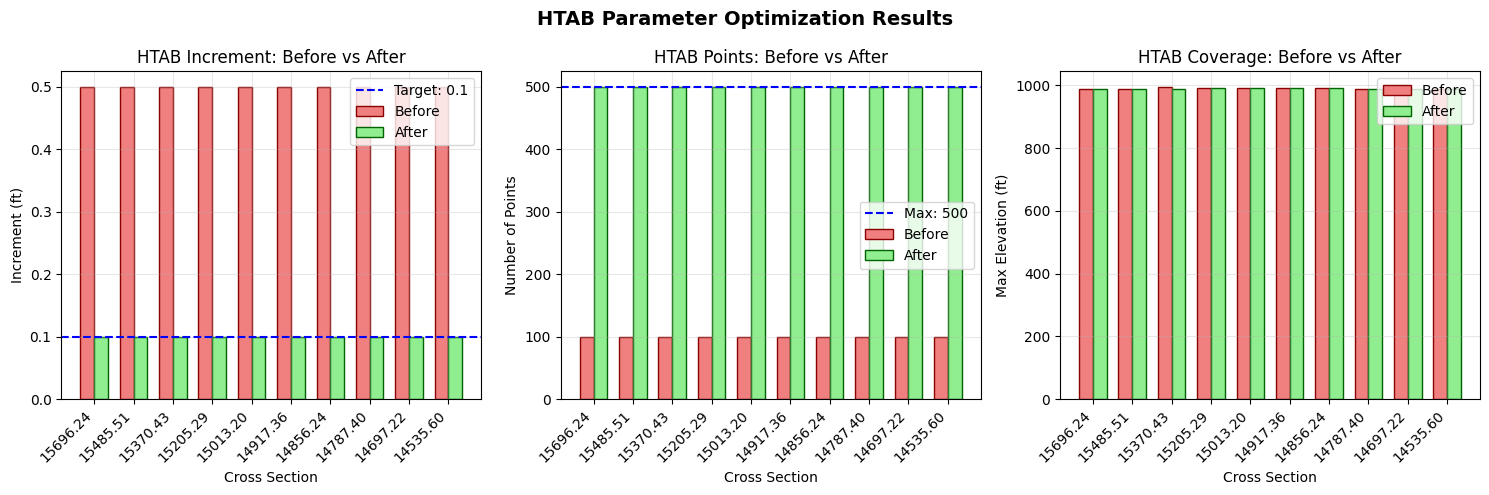

In [17]:
# Visualize before/after comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(len(comparison_df))
width = 0.35
rs_labels = [str(rs)[:8] for rs in comparison_df['RS_Original']]

# Plot 1: Increment comparison
ax1 = axes[0]
ax1.bar(x - width/2, comparison_df['Increment_Original'], width, 
        label='Before', color='lightcoral', edgecolor='darkred')
ax1.bar(x + width/2, comparison_df['Increment_Optimized'], width, 
        label='After', color='lightgreen', edgecolor='darkgreen')
ax1.axhline(y=TARGET_INCREMENT, color='blue', linestyle='--', label=f'Target: {TARGET_INCREMENT}')
ax1.set_xlabel('Cross Section')
ax1.set_ylabel('Increment (ft)')
ax1.set_title('HTAB Increment: Before vs After')
ax1.set_xticks(x)
ax1.set_xticklabels(rs_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Number of points comparison
ax2 = axes[1]
ax2.bar(x - width/2, comparison_df['Num_Points_Original'], width, 
        label='Before', color='lightcoral', edgecolor='darkred')
ax2.bar(x + width/2, comparison_df['Num_Points_Optimized'], width, 
        label='After', color='lightgreen', edgecolor='darkgreen')
ax2.axhline(y=MAX_POINTS, color='blue', linestyle='--', label=f'Max: {MAX_POINTS}')
ax2.set_xlabel('Cross Section')
ax2.set_ylabel('Number of Points')
ax2.set_title('HTAB Points: Before vs After')
ax2.set_xticks(x)
ax2.set_xticklabels(rs_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Coverage (max elevation)
ax3 = axes[2]
ax3.bar(x - width/2, comparison_df['Max_El_Original'], width, 
        label='Before', color='lightcoral', edgecolor='darkred')
ax3.bar(x + width/2, comparison_df['Max_El_Optimized'], width, 
        label='After', color='lightgreen', edgecolor='darkgreen')
ax3.set_xlabel('Cross Section')
ax3.set_ylabel('Max Elevation (ft)')
ax3.set_title('HTAB Coverage: Before vs After')
ax3.set_xticks(x)
ax3.set_xticklabels(rs_labels, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

fig.suptitle('HTAB Parameter Optimization Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Section 7: Run Optimized Plan

Execute the cloned plan with optimized HTAB parameters. The original baseline plan remains unchanged for comparison.

In [18]:
# Run the CLONED plan with optimized HTAB parameters
print(f"Running optimized plan (p{optimized_plan_number}) with optimized HTAB parameters...")
print("(Using force_geompre=True to rebuild hydraulic tables)\n")

result = RasCmdr.compute_plan(
    optimized_plan_number,  # Run the CLONED plan
    num_cores=4, 
    force_geompre=True,  # Force geometry preprocessing to use new HTAB
    force_rerun=True
)

if result:
    print(f"Optimized simulation (plan {optimized_plan_number}) completed successfully")
else:
    print(f"ERROR: Optimized simulation (plan {optimized_plan_number}) failed")

2026-01-14 10:34:01 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab
2026-01-14 10:34:01 - ras_commander.RasCurrency - INFO - Deleted geometry HDF: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.hdf
2026-01-14 10:34:01 - ras_commander.geom.GeomPreprocessor - INFO - Clearing geometry preprocessor file for single plan: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02
2026-01-14 10:34:01 - ras_commander.geom.GeomPreprocessor - WARNING - No geometry preprocessor file found for: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02
2026-01-14 10:34:01 - ras_commander.geom.GeomPreprocessor - INFO - Geometry dataframe updated successfully.
2026-01-14 10:34:01 - ras_commander.RasCmdr - INFO - Force-cleared all geometry preprocessor files for plan: 02
2026-01-14 10:34:01 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras

Running optimized plan (p02) with optimized HTAB parameters...
(Using force_geompre=True to rebuild hydraulic tables)



2026-01-14 10:34:16 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 02
2026-01-14 10:34:16 - ras_commander.RasCmdr - INFO - Total run time for plan 02: 15.71 seconds
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 2829 characters from HDF
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - 

Optimized simulation (plan 02) completed successfully


In [19]:
# Parse optimized compute messages
# Refresh plan_df to get updated HDF path for the OPTIMIZED plan
ras.plan_df = ras.get_plan_entries()  # Refresh to get updated HDF paths
optimized_plan_row = ras.plan_df[ras.plan_df['plan_number'] == optimized_plan_number].iloc[0]
hdf_path_optimized = Path(optimized_plan_row['HDF_Results_Path'])

print(f"Optimized plan HDF: {hdf_path_optimized.name}")

# Get compute messages text from HDF
compute_msgs_optimized = HdfResultsPlan.get_compute_messages(hdf_path_optimized)

# Parse messages
compute_result_optimized = ResultsParser.parse_compute_messages(compute_msgs_optimized)

# Check for extrapolation mentions
optimized_extrap_count = compute_msgs_optimized.lower().count('extrapolat')

print("\nCompute Messages Comparison:")
print(f"  Baseline (plan {PLAN_NUMBER}): {baseline_extrap_count} extrapolation mentions")
print(f"  Optimized (plan {optimized_plan_number}): {optimized_extrap_count} extrapolation mentions")

if optimized_extrap_count < baseline_extrap_count:
    reduction = ((baseline_extrap_count - optimized_extrap_count) / max(baseline_extrap_count, 1)) * 100
    print(f"\n  Improvement: {reduction:.1f}% reduction in extrapolation warnings")
elif optimized_extrap_count == 0 and baseline_extrap_count == 0:
    print("\n  No extrapolation warnings in either run (model was already well-configured)")
else:
    print("\n  Note: Additional optimization may be needed")

2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 2829 characters from HDF


Optimized plan HDF: Muncie.p02.hdf

Compute Messages Comparison:
  Baseline (plan 01): 0 extrapolation mentions
  Optimized (plan 02): 1 extrapolation mentions

  Note: Additional optimization may be needed


In [20]:
# Create summary table
print("\n" + "="*60)
print("HTAB OPTIMIZATION SUMMARY")
print("="*60)

summary_data = {
    'Metric': [
        'Baseline Plan',
        'Optimized Plan',
        'Baseline Geometry',
        'Optimized Geometry',
        'Cross Sections Modified',
        'Structures Modified',
        'Extrapolation Warnings (Baseline)',
        'Extrapolation Warnings (Optimized)',
        'Warning Reduction',
        'Safety Factor Applied',
        'Backup Created'
    ],
    'Value': [
        f"p{PLAN_NUMBER}",
        f"p{optimized_plan_number}",
        "g01 (original HTAB)",
        f"g{new_geom_number} (optimized HTAB)",
        optimization_result['xs_modified'],
        optimization_result['structures_modified'],
        baseline_extrap_count,
        optimized_extrap_count,
        f"{max(0, baseline_extrap_count - optimized_extrap_count)} ({((max(0, baseline_extrap_count - optimized_extrap_count) / max(baseline_extrap_count, 1)) * 100):.0f}%)",
        f"{XS_SAFETY_FACTOR}x ({(XS_SAFETY_FACTOR-1)*100:.0f}%)",
        'Yes' if optimization_result['backup'] else 'No'
    ]
}

summary_table = pd.DataFrame(summary_data)
display.display(summary_table)


HTAB OPTIMIZATION SUMMARY


,Metric,Value
0,Baseline Plan,p01
1,Optimized Plan,p02
2,Baseline Geometry,g01 (original HTAB)
3,Optimized Geometry,g03 (optimized HTAB)
4,Cross Sections Modified,61
5,Structures Modified,0
6,Extrapolation Warnings (Baseline),0
7,Extrapolation Warnings (Optimized),1
8,Warning Reduction,0 (0%)
9,Safety Factor Applied,1.3x (30%)


## Section 8: Compare Results Using results_df and Max WSEL

Now that we have both baseline and optimized plans executed, we can compare their results using:
1. **results_df**: Compare execution metadata, runtime, and volume accounting
2. **Max WSEL comparison**: Assess computational differences between HTAB configurations

In [21]:
# Compare results using results_df
print("="*60)
print("RESULTS COMPARISON: results_df")
print("="*60)

# Display results_df for comparison
print("\nExecution Summary (results_df transposed for readability):")
display.display(ras.results_df.T)

# Extract key metrics for comparison
baseline_results = ras.results_df[ras.results_df['plan_number'] == PLAN_NUMBER]
optimized_results = ras.results_df[ras.results_df['plan_number'] == optimized_plan_number]

if not baseline_results.empty and not optimized_results.empty:
    print("\n" + "-"*60)
    print("KEY METRICS COMPARISON")
    print("-"*60)
    
    # Runtime comparison
    baseline_runtime = baseline_results['runtime_complete_process_hours'].values[0]
    optimized_runtime = optimized_results['runtime_complete_process_hours'].values[0]
    
    print(f"\nCompute Time (hours):")
    print(f"  Baseline (p{PLAN_NUMBER}):  {baseline_runtime:.6f}")
    print(f"  Optimized (p{optimized_plan_number}): {optimized_runtime:.6f}")
    if baseline_runtime and optimized_runtime:
        runtime_diff = ((optimized_runtime - baseline_runtime) / baseline_runtime) * 100
        print(f"  Difference: {runtime_diff:+.1f}%")
    
    # Volume accounting comparison
    baseline_vol_err = baseline_results['vol_error_percent'].values[0]
    optimized_vol_err = optimized_results['vol_error_percent'].values[0]
    
    print(f"\nVolume Error (%):")
    print(f"  Baseline (p{PLAN_NUMBER}):  {baseline_vol_err:.6f}")
    print(f"  Optimized (p{optimized_plan_number}): {optimized_vol_err:.6f}")
    
    # Completion status
    baseline_completed = baseline_results['completed'].values[0]
    optimized_completed = optimized_results['completed'].values[0]
    
    print(f"\nCompletion Status:")
    print(f"  Baseline (p{PLAN_NUMBER}):  {'✓ Completed' if baseline_completed else '✗ Failed'}")
    print(f"  Optimized (p{optimized_plan_number}): {'✓ Completed' if optimized_completed else '✗ Failed'}")

RESULTS COMPARISON: results_df

Execution Summary (results_df transposed for readability):


,0,1,2,3
plan_number,01,03,04,02
plan_title,Unsteady Multi 9-SA run,Unsteady Run with 2D 50ft Grid,Unsteady Run with 2D 50ft User n Value R,HTAB Optimized Plan
flow_type,Unsteady,Unsteady,Unsteady,Unsteady
hdf_path,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
hdf_exists,True,False,False,True
hdf_file_modified,2026-01-14 10:33:57.814524,NaT,NaT,2026-01-14 10:34:16.554690
ras_version,5.00,5.10,5.10,5.00
completed,True,False,False,True
has_errors,False,False,False,False
has_warnings,False,False,False,True



------------------------------------------------------------
KEY METRICS COMPARISON
------------------------------------------------------------

Compute Time (hours):
  Baseline (p01):  0.003867
  Optimized (p02): 0.003876
  Difference: +0.2%

Volume Error (%):
  Baseline (p01):  0.000750
  Optimized (p02): 0.004106

Completion Status:
  Baseline (p01):  ✓ Completed
  Optimized (p02): ✓ Completed


In [22]:
# Extract max WSEL from optimized plan and compare with baseline
print("="*60)
print("MAX WSEL COMPARISON: Baseline vs Optimized")
print("="*60)

try:
    # Extract max WSE from optimized plan results
    xs_results_optimized = HdfResultsXsec.get_xsec_timeseries(hdf_path_optimized)
    
    optimized_max_wse_df = pd.DataFrame({
        'cross_section': xs_results_optimized.coords['cross_section'].values,
        'river': xs_results_optimized.coords['River'].values,
        'reach': xs_results_optimized.coords['Reach'].values,
        'station': xs_results_optimized.coords['Station'].values,
        'max_wse_optimized': xs_results_optimized.coords['Maximum_Water_Surface'].values
    })
    
    # Merge baseline and optimized max WSE
    if baseline_max_wse_df is not None:
        comparison_wse_df = pd.merge(
            baseline_max_wse_df,
            optimized_max_wse_df,
            on=['cross_section', 'river', 'reach', 'station'],
            how='inner'
        )
        
        # Calculate differences
        comparison_wse_df['wse_diff'] = comparison_wse_df['max_wse_optimized'] - comparison_wse_df['max_wse_baseline']
        comparison_wse_df['wse_diff_abs'] = comparison_wse_df['wse_diff'].abs()
        
        # Summary statistics
        print(f"\nCross sections compared: {len(comparison_wse_df)}")
        print(f"\nMax WSEL Difference Statistics:")
        print(f"  Min difference:  {comparison_wse_df['wse_diff'].min():.4f} ft")
        print(f"  Max difference:  {comparison_wse_df['wse_diff'].max():.4f} ft")
        print(f"  Mean difference: {comparison_wse_df['wse_diff'].mean():.4f} ft")
        print(f"  Std deviation:   {comparison_wse_df['wse_diff'].std():.4f} ft")
        print(f"  Max absolute:    {comparison_wse_df['wse_diff_abs'].max():.4f} ft")
        
        # Display first 15 rows of comparison
        print("\nDetailed Comparison (first 15 cross sections):")
        display_cols = ['cross_section', 'max_wse_baseline', 'max_wse_optimized', 'wse_diff']
        display.display(comparison_wse_df[display_cols].head(15))
        
        # Identify cross sections with significant differences
        threshold = 0.01  # ft
        significant_diff = comparison_wse_df[comparison_wse_df['wse_diff_abs'] > threshold]
        
        if len(significant_diff) > 0:
            print(f"\nCross sections with |WSEL diff| > {threshold} ft: {len(significant_diff)}")
            display.display(significant_diff[display_cols])
        else:
            print(f"\n✓ All cross sections have WSEL differences ≤ {threshold} ft")
            print("  HTAB optimization has negligible impact on computed water surface elevations.")
    else:
        print("Baseline max WSE data not available for comparison.")
        
except Exception as e:
    print(f"Error comparing max WSE: {e}")

2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsXsec - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf
2026-01-14 10:34:16 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.p02.hdf


MAX WSEL COMPARISON: Baseline vs Optimized

Cross sections compared: 61

Max WSEL Difference Statistics:
  Min difference:  0.0026 ft
  Max difference:  0.2300 ft
  Mean difference: 0.0177 ft
  Std deviation:   0.0484 ft
  Max absolute:    0.2300 ft

Detailed Comparison (first 15 cross sections):


,cross_section,max_wse_baseline,max_wse_optimized,wse_diff
0,White Muncie 15696.24,955.419312,955.625916,0.206604
1,White Muncie 15485.51,955.174011,955.392578,0.218567
2,White Muncie 15370.43,954.952271,955.182251,0.229980
3,White Muncie 15205.29,954.893005,955.013062,0.120056
4,White Muncie 15013.20,954.560486,954.564758,0.004272
5,White Muncie 14917.36,953.986633,953.990967,0.004333
6,White Muncie 14856.24,953.586487,953.590881,0.004395
7,White Muncie 14787.40,953.695190,953.699402,0.004211
8,White Muncie 14697.22,953.339478,953.343750,0.004272
9,White Muncie 14535.60,953.233215,953.237549,0.004333



Cross sections with |WSEL diff| > 0.01 ft: 4


,cross_section,max_wse_baseline,max_wse_optimized,wse_diff
0,White Muncie 15696.24,955.419312,955.625916,0.206604
1,White Muncie 15485.51,955.174011,955.392578,0.218567
2,White Muncie 15370.43,954.952271,955.182251,0.229980
3,White Muncie 15205.29,954.893005,955.013062,0.120056


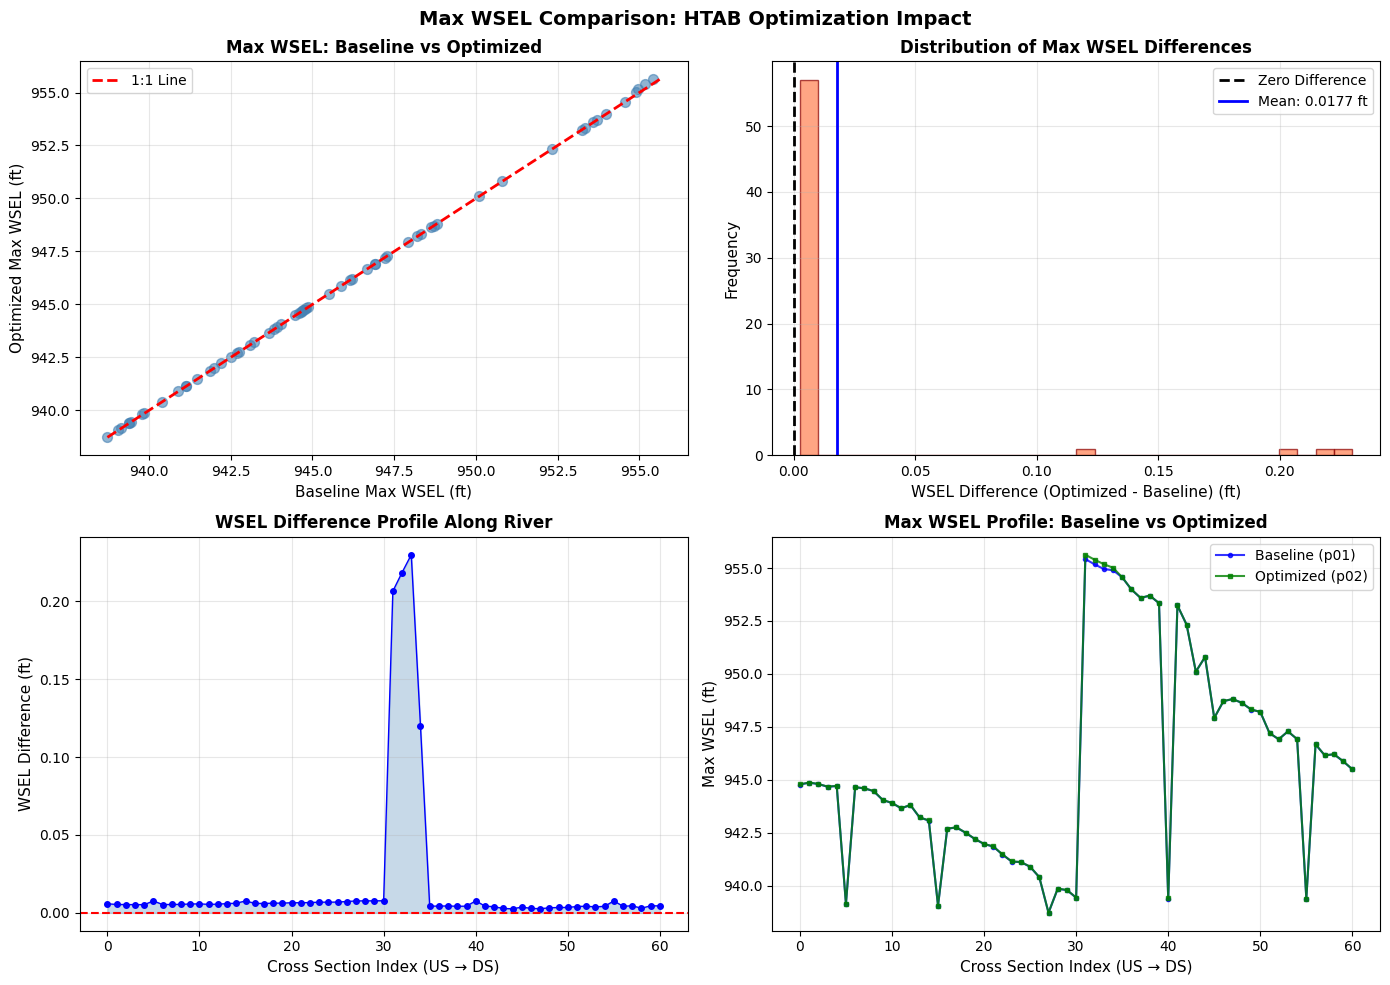


Interpretation:
- Top-left: Points on the 1:1 line indicate identical results
- Top-right: Histogram shows distribution of differences (centered at 0 = no impact)
- Bottom-left: Profile view shows where differences occur along the river
- Bottom-right: Direct comparison of water surface profiles


In [23]:
# Visualize max WSEL comparison
if 'comparison_wse_df' in dir() and comparison_wse_df is not None and len(comparison_wse_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Baseline vs Optimized Max WSEL scatter plot
    ax1 = axes[0, 0]
    ax1.scatter(comparison_wse_df['max_wse_baseline'], 
                comparison_wse_df['max_wse_optimized'], 
                alpha=0.6, s=50, c='steelblue')
    
    # Add 1:1 line
    min_val = min(comparison_wse_df['max_wse_baseline'].min(), 
                  comparison_wse_df['max_wse_optimized'].min())
    max_val = max(comparison_wse_df['max_wse_baseline'].max(), 
                  comparison_wse_df['max_wse_optimized'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')
    
    ax1.set_xlabel('Baseline Max WSEL (ft)', fontsize=11)
    ax1.set_ylabel('Optimized Max WSEL (ft)', fontsize=11)
    ax1.set_title('Max WSEL: Baseline vs Optimized', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: WSEL Difference histogram
    ax2 = axes[0, 1]
    ax2.hist(comparison_wse_df['wse_diff'], bins=30, color='coral', edgecolor='darkred', alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Difference')
    ax2.axvline(x=comparison_wse_df['wse_diff'].mean(), color='blue', linestyle='-', 
                linewidth=2, label=f"Mean: {comparison_wse_df['wse_diff'].mean():.4f} ft")
    ax2.set_xlabel('WSEL Difference (Optimized - Baseline) (ft)', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Distribution of Max WSEL Differences', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: WSEL difference along river station
    ax3 = axes[1, 0]
    # Sort by station for profile view
    sorted_df = comparison_wse_df.sort_values('station', ascending=False)
    ax3.plot(range(len(sorted_df)), sorted_df['wse_diff'].values, 'b-o', 
             markersize=4, linewidth=1, label='WSEL Difference')
    ax3.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    ax3.fill_between(range(len(sorted_df)), 0, sorted_df['wse_diff'].values, 
                     alpha=0.3, color='steelblue')
    ax3.set_xlabel('Cross Section Index (US → DS)', fontsize=11)
    ax3.set_ylabel('WSEL Difference (ft)', fontsize=11)
    ax3.set_title('WSEL Difference Profile Along River', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Max WSEL profile comparison
    ax4 = axes[1, 1]
    ax4.plot(range(len(sorted_df)), sorted_df['max_wse_baseline'].values, 
             'b-o', markersize=3, linewidth=1.5, label=f'Baseline (p{PLAN_NUMBER})', alpha=0.8)
    ax4.plot(range(len(sorted_df)), sorted_df['max_wse_optimized'].values, 
             'g-s', markersize=3, linewidth=1.5, label=f'Optimized (p{optimized_plan_number})', alpha=0.8)
    ax4.set_xlabel('Cross Section Index (US → DS)', fontsize=11)
    ax4.set_ylabel('Max WSEL (ft)', fontsize=11)
    ax4.set_title('Max WSEL Profile: Baseline vs Optimized', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    fig.suptitle('Max WSEL Comparison: HTAB Optimization Impact', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Top-left: Points on the 1:1 line indicate identical results")
    print("- Top-right: Histogram shows distribution of differences (centered at 0 = no impact)")
    print("- Bottom-left: Profile view shows where differences occur along the river")
    print("- Bottom-right: Direct comparison of water surface profiles")
else:
    print("WSEL comparison data not available for visualization.")

## Section 9: Advanced Examples

Demonstrate additional HTAB optimization scenarios.

In [24]:
# Example 1: XS-only optimization with custom safety factor
print("Example 1: XS-Only Optimization")
print("-" * 40)

# Calculate optimal parameters for a single cross section
sample_xs = xs_df.iloc[0]
params = GeomCrossSection.get_xs_htab_params(
    geom_file, sample_xs['River'], sample_xs['Reach'], sample_xs['RS']
)

# Get max WSE for this XS
if max_wse_df is not None:
    sample_max_wse = max_wse_df.iloc[0]['max_wse']
    invert = params.get('invert') or sample_max_wse - 20
    
    # Calculate optimal parameters with different safety factors
    for sf in [1.2, 1.3, 1.5, 2.0]:
        optimal = GeomHtabUtils.calculate_optimal_xs_htab(
            invert=invert,
            max_wse=sample_max_wse,
            safety_factor=sf,
            target_increment=0.1,
            max_points=500
        )
        print(f"  Safety {sf}x: Inc={optimal['increment']:.3f}, "
              f"Points={optimal['num_points']}, "
              f"Max El={optimal['actual_max_el']:.1f}")

2026-01-14 10:34:17 - ras_commander.geom.GeomCrossSection - INFO - Extracted 134 station/elevation pairs for White/Muncie/RS 15696.24
2026-01-14 10:34:17 - ras_commander.geom.GeomCrossSection - INFO - Extracted HTAB params for White/Muncie/RS 15696.24: has_htab_lines=True, starting_el=937.99, increment=0.5, num_points=100
2026-01-14 10:34:17 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=936.99, increment=0.1, num_points=500, actual_max_el=986.89
2026-01-14 10:34:17 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=936.99, increment=0.1, num_points=500, actual_max_el=986.89
2026-01-14 10:34:17 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=936.99, increment=0.1, num_points=500, actual_max_el=986.89
2026-01-14 10:34:17 - ras_commander.geom.GeomHtabUtils - INFO - Optimal XS HTAB: starting_el=936.99, increment=0.1, num_points=500, actual_max_el=986.89


Example 1: XS-Only Optimization
----------------------------------------
  Safety 1.2x: Inc=0.100, Points=500, Max El=986.9
  Safety 1.3x: Inc=0.100, Points=500, Max El=986.9
  Safety 1.5x: Inc=0.100, Points=500, Max El=986.9
  Safety 2.0x: Inc=0.100, Points=500, Max El=986.9


In [25]:
# Quick reference: View results_df for all plans
# (Detailed comparison is in Section 8 above)
# Uncomment to display:
# ras.results_df.T

In [26]:
# Example 2: Structure HTAB calculation
print("\nExample 2: Structure HTAB Calculation")
print("-" * 40)

# Demonstrate structure HTAB calculation
struct_invert = 580.0
max_hw = 605.0
max_tw = 600.0
max_flow = 25000.0

struct_optimal = GeomHtabUtils.calculate_optimal_structure_htab(
    struct_invert=struct_invert,
    max_hw=max_hw,
    max_tw=max_tw,
    max_flow=max_flow,
    hw_safety=2.0,
    flow_safety=2.0,
    tw_safety=2.0
)

print(f"  Input: Invert={struct_invert}, Max HW={max_hw}, Max Flow={max_flow:,.0f}")
print(f"  Output:")
print(f"    HW Max: {struct_optimal['hw_max']:.1f} ft (safety applied to range above invert)")
print(f"    TW Max: {struct_optimal['tw_max']:.1f} ft")
print(f"    Max Flow: {struct_optimal['max_flow']:,.0f} cfs")
print(f"    Free Flow Points: {struct_optimal['free_flow_points']}")
print(f"    Submerged Curves: {struct_optimal['submerged_curves']}")

2026-01-14 10:34:17 - ras_commander.geom.GeomHtabUtils - INFO - Optimal structure HTAB: hw_max=630.00, tw_max=620.00, max_flow=50000.00, free_flow_points=20, submerged_curves=30



Example 2: Structure HTAB Calculation
----------------------------------------
  Input: Invert=580.0, Max HW=605.0, Max Flow=25,000
  Output:
    HW Max: 630.0 ft (safety applied to range above invert)
    TW Max: 620.0 ft
    Max Flow: 50,000 cfs
    Free Flow Points: 20
    Submerged Curves: 30


In [27]:
# Example 3: HTAB defaults reference
print("\nExample 3: HTAB Parameter Defaults")
print("-" * 40)

xs_defaults = GeomHtabUtils.get_xs_htab_defaults()
print("\nCross Section HTAB Defaults:")
for key, value in xs_defaults.items():
    print(f"  {key}: {value}")

struct_defaults = GeomHtabUtils.get_structure_htab_defaults()
print("\nStructure HTAB Defaults:")
for key, value in struct_defaults.items():
    print(f"  {key}: {value}")


Example 3: HTAB Parameter Defaults
----------------------------------------

Cross Section HTAB Defaults:
  increment: 0.1
  num_points: 500
  safety_factor: 1.3
  min_points: 20
  max_points: 500
  min_increment: 0.01
  max_increment: 2.0

Structure HTAB Defaults:
  hw_safety: 2.0
  tw_safety: 2.0
  flow_safety: 2.0
  free_flow_points: 20
  submerged_curves: 30
  points_per_curve: 20
  min_free_flow_points: 10
  max_free_flow_points: 20
  min_submerged_curves: 10
  max_submerged_curves: 30


## Cleanup

In [28]:
# Optional: Remove extracted project
# Uncomment to clean up

# import shutil
# if project_path.exists():
#     shutil.rmtree(project_path)
#     print(f"Removed: {project_path}")

print("Notebook complete. Project files retained for inspection.")
print(f"\nProject location: {project_path}")
if optimization_result.get('backup'):
    print(f"Backup file: {optimization_result['backup']}")

Notebook complete. Project files retained for inspection.

Project location: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab
Backup file: C:\GH\ras-commander\examples\example_projects\Muncie_203_htab\Muncie.g03.bak


## Summary

### What We Demonstrated

1. **Inspected Original HTAB**: Read current XS and structure HTAB parameters from geometry file
2. **Baseline Execution**: Ran simulation with default parameters and checked for warnings
3. **Results Analysis**: Extracted maximum WSE values to understand required coverage
4. **Plan/Geometry Cloning**: Used `RasPlan.clone_plan()` and `RasPlan.clone_geom()` to preserve baseline
5. **HTAB Optimization**: Applied `GeomHtab.optimize_all_htab_from_results()` to cloned geometry only
6. **Optimized Plan Execution**: Ran cloned plan with optimized HTAB parameters
7. **Results Comparison**: Used `results_df` and max WSEL comparison to assess computational differences
8. **Verification**: Confirmed optimization impact (or lack thereof) on water surface elevations

### Key Functions

| Function | Purpose |
|----------|----------|
| `RasPlan.clone_plan()` | Clone a plan to preserve baseline for comparison |
| `RasPlan.clone_geom()` | Clone a geometry for isolated modifications |
| `RasPlan.set_geom()` | Associate cloned plan with cloned geometry |
| `GeomHtab.optimize_all_htab_from_results()` | One-call optimization of all HTAB parameters |
| `GeomHtab.get_optimization_report()` | Preview optimization without modifying |
| `GeomCrossSection.get_xs_htab_params()` | Read current XS HTAB parameters |
| `GeomHtabUtils.calculate_optimal_xs_htab()` | Calculate optimal XS parameters |
| `HdfResultsXsec.get_xsec_timeseries()` | Extract cross section results for comparison |

### Plan Cloning Pattern

**Why Clone?**: Cloning allows side-by-side comparison without modifying the original baseline:

```python
# Clone geometry and apply modifications
new_geom = RasPlan.clone_geom("01")
GeomHtab.optimize_all_htab_from_results(cloned_geom_file, ...)

# Clone plan and associate with modified geometry
new_plan = RasPlan.clone_plan("01", new_shortid="Optimized")
RasPlan.set_geom(new_plan, new_geom)

# Run both and compare
RasCmdr.compute_plan("01")  # Baseline
RasCmdr.compute_plan(new_plan)  # Optimized

# Compare using results_df
ras.results_df.T  # View all plan results side-by-side
```

### Best Practices

- **Clone before modifying**: Preserve baseline for comparison
- **Use results_df**: Compare runtime, volume error, and completion status
- **Compare max WSEL**: Quantify computational impact of HTAB changes
- **Always create backups**: Use `create_backup=True` (default)
- **Force geometry preprocessing**: After HTAB changes, run with `force_geompre=True`
- **Use appropriate safety factors**:
  - Typical floods: 1.3x (30% safety)
  - Dam break/extreme events: 2.0x (100% safety)

### Known Issues / Roadmap

⚠️ **HTAB Starting Elevation Bug** (See DEV NOTE in Section 5):
- Current implementation may set `starting_el` below XS invert
- HEC-RAS GUI will display warning and reset values
- **Fix Required:** Validate `starting_el >= invert` and round up to nearest 0.01 ft
- Tracked in: `ras_commander/geom/GeomHtabUtils.py`

### See Also

- `103_plan_and_geometry_operations.ipynb` - Plan and geometry cloning patterns
- `201_1d_plaintext_geometry.ipynb` - Cross section and HTAB basics
- `400_1d_hdf_data_extraction.ipynb` - Extracting results data
- `ras_commander/geom/GeomHtab.py` - Complete HTAB optimization API